In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras import optimizers
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load heart data

In [2]:
data = pd.read_csv('../data/heart.txt')
data = data.dropna()

data.head()

Unnamed: 0  Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  \
0           1   63    1       typical     145   233    1        2    150   
1           2   67    1  asymptomatic     160   286    0        2    108   
2           3   67    1  asymptomatic     120   229    0        2    129   
3           4   37    1    nonanginal     130   250    0        0    187   
4           5   41    0    nontypical     130   204    0        2    172   

   ExAng  Oldpeak  Slope   Ca        Thal  AHD  
0      0      2.3      3  0.0       fixed   No  
1      1      1.5      2  3.0      normal  Yes  
2      1      2.6      2  2.0  reversable  Yes  
3      0      3.5      3  0.0      normal   No  
4      0      1.4      1  0.0      normal   No

## Pre-process data

In [3]:
# One-hot encoding of categorical attributes
x = data.ix[:,1:-1]
x = pd.get_dummies(x).as_matrix()

# Obtain labels and encode as {0, 1}
y = data.ix[:,-1]
y = (y=='Yes').as_matrix()*1.0

# Normalize features
x = (x - x.mean(axis=0)) / x.std(axis=0)

# Split train-test sets
n = x.shape[0]
perm = np.random.permutation(n)
n_tr = int(np.round(n*0.5))

x_train = x[perm[0:n_tr],:]
y_train = y[perm[0:n_tr]]

x_test = x[perm[n_tr:],:]
y_test = y[perm[n_tr:]]

## Train neural network with 1 hidden layer

In [4]:
def train_nn(x_train, y_train, num_hidden_nodes):
    # Construct neural network model
    model = Sequential()
    model.add(Dense(num_hidden_nodes, activation='relu', input_shape=(x_train.shape[1],))) # hidden layer
    model.add(Dense(1, activation='sigmoid')) # output layer
    
    # Optimizer: SGD (loss = binary cross entropy)
    sgd = SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit neural network
    model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0)
    
    return model

In [97]:
model = train_nn(x_train, y_train, 100)

# Evaluate train and test accuracy
tr_acc = model.evaluate(x_train, y_train, verbose=0)[1]
ts_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    
print('Plain neural network')
print('Train accuracy: ' + str(tr_acc))
print('Test accuracy: ' + str(ts_acc))

Plain neural network
Train accuracy: 1.0
Test accuracy: 0.785234901729


## Train neural network with L2 regularization 

In [75]:
def train_nn_l2(x_train, y_train, num_hidden_nodes, reg_param):
    # Construct neural network model
    model = Sequential()
    reg = l2(reg_param)
    
    model.add(Dense(num_hidden_nodes, activation='relu', input_shape=(x_train.shape[1],),\
                        kernel_regularizer = reg)) # hidden layer, with L2 regularizer
    model.add(Dense(1, activation='sigmoid',\
                        kernel_regularizer = reg)) # output layer, with L2 regularizer
    
    # Optimizer: SGD (loss = binary cross entropy)
    sgd = SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit neural network
    model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0)
    
    return model

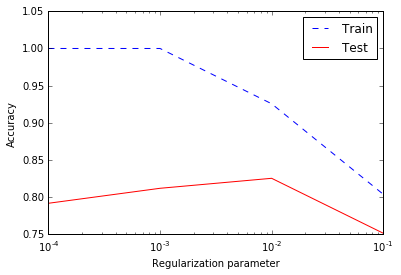

In [58]:
# List of regularizer parameters
reg_params = [0.0001, 0.0001, 0.001, 0.01, 0.1]
num_params = len(reg_params)

# Iterate over parameters
tr_acc = np.zeros(num_params,)
ts_acc = np.zeros(num_params,)

for i in range(num_params):
    # Train neural network with L2 regularization
    model = train_nn_l2(x_train, y_train, 100, reg_params[i])
    
    # Evaluate train and test accuracy
    tr_acc[i] = model.evaluate(x_train, y_train, verbose=0)[1]
    ts_acc[i] = model.evaluate(x_test, y_test, verbose=0)[1]
    
# Plot train and test accuracy as a function of reg parameter
plt.semilogx(reg_params, tr_acc, '--b', label='Train')
plt.semilogx(reg_params, ts_acc, 'r', label='Test')
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.title('L2 regularization')
plt.legend()

## Train neural network with L1 regularization 

In [63]:
def train_nn_l1(x_train, y_train, num_hidden_nodes, reg_param):
    # Construct neural network model
    model = Sequential()
    reg = l1(reg_param)
    
    model.add(Dense(num_hidden_nodes, activation='relu', input_shape=(x_train.shape[1],),\
                        kernel_regularizer = reg)) # hidden layer, with L2 regularizer
    model.add(Dense(1, activation='sigmoid',\
                        kernel_regularizer = reg)) # output layer, with L2 regularizer
    
    # Optimizer: SGD (loss = binary cross entropy)
    sgd = SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit neural network
    model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0)
    
    return model

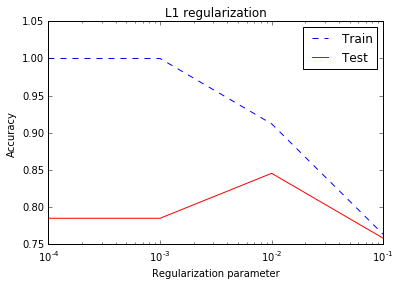

In [64]:
# List of regularizer parameters
reg_params = [0.0001, 0.0001, 0.001, 0.01, 0.1]
num_params = len(reg_params)

# Iterate over parameters
tr_acc = np.zeros(num_params,)
ts_acc = np.zeros(num_params,)

for i in range(num_params):
    # Train neural network with L1 regularization
    model = train_nn_l1(x_train, y_train, 100, reg_params[i])
    
    # Evaluate train and test accuracy
    tr_acc[i] = model.evaluate(x_train, y_train, verbose=0)[1]
    ts_acc[i] = model.evaluate(x_test, y_test, verbose=0)[1]
    
# Plot train and test accuracy as a function of reg parameter
plt.semilogx(reg_params, tr_acc, '--b', label='Train')
plt.semilogx(reg_params, ts_acc, 'r', label='Test')
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.title('L1 regularization')
plt.legend()

## Train neural network with early stopping

In [86]:
def train_nn_earlystop(x_train, y_train, num_hidden_nodes, x_val, y_val):
    # Construct neural network model
    model = Sequential()    
    model.add(Dense(num_hidden_nodes, activation='relu', input_shape=(x_train.shape[1],))) # hidden layer
    model.add(Dense(1, activation='sigmoid')) # output layer
    
    # Early stopping call back
    e_stop = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
    
    # Optimizer: SGD (loss = binary cross entropy)
    sgd = SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit neural network
    model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0,\
              callbacks=[e_stop], validation_data=(x_val, y_val))
    
    return model

In [88]:
model = train_nn(x_train, y_train, 100)

# Evaluate train and test accuracy
tr_acc = model.evaluate(x_train, y_train, verbose=0)[1]
ts_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    
print('Plain neural network')
print('Train accuracy: ' + str(tr_score))
print('Test accuracy: ' + str(ts_score))

print

model = train_nn_earlystop(x_train, y_train, 100, x_test, y_test)

# Evaluate train and test accuracy
tr_acc = model.evaluate(x_train, y_train, verbose=0)[1]
ts_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    
print('Neural network with early stopping')
print('Train accuracy: ' + str(tr_acc))
print('Test accuracy: ' + str(ts_acc))

Plain neural network
Train accuracy: 1.0
Test accuracy: 0.744966444953

Neural network with early stopping
Train accuracy: 0.89189188867
Test accuracy: 0.818791947509


## Train neural network with dropout

In [67]:
def train_nn_dropout(x_train, y_train, num_hidden_nodes, do_rate):
    # Construct neural network model
    model = Sequential() 
    model.add(Dropout(do_rate, input_shape=(x.shape[1],))) # drop out on input nodes
    model.add(Dense(num_hidden_nodes, activation='relu')) # hidden layer
    model.add(Dropout(do_rate)) # drop out on hidden nodes
    model.add(Dense(1, activation='sigmoid')) # output layer
    
    # Optimizer: SGD (loss = binary cross entropy)
    sgd = SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit neural network
    model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0)
    
    return model

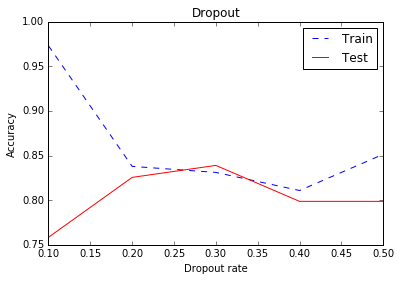

In [71]:
# List of regularizer parameters
do_params = [0.1,0.2,0.3,0.4,0.5]
num_params = len(do_params)

# Iterate over parameters
tr_acc = np.zeros(num_params,)
ts_acc = np.zeros(num_params,)

for i in range(num_params):
    # Train neural network with L2 regularization
    model = train_nn_dropout(x_train, y_train, 100, do_params[i])
    
    # Evaluate train and test accuracy
    tr_acc[i] = model.evaluate(x_train, y_train, verbose=0)[1]
    ts_acc[i] = model.evaluate(x_test, y_test, verbose=0)[1]
    
# Plot train and test accuracy as a function of reg parameter
plt.plot(do_params, tr_acc, '--b', label='Train')
plt.plot(do_params, ts_acc, 'r', label='Test')
plt.xlabel('Dropout rate')
plt.ylabel('Accuracy')
plt.title('Dropout')
plt.legend()

## Does the network overfit? [remove]

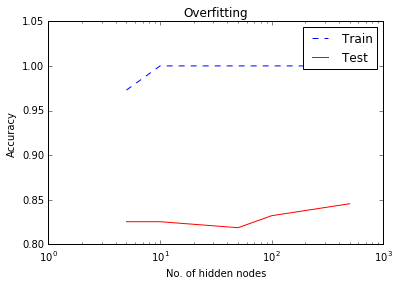

In [13]:
# No. of hidden nodes
num_hidden = [5,10,50,100,500]
num_params = len(num_hidden)

# Iterate over parameters
tr_acc = np.zeros(num_params,)
ts_acc = np.zeros(num_params,)

for i in range(num_params):
    # Train neural network with num_hidden[i] hidden nodes
    model = train_nn(x_train, y_train, num_hidden[i])

    # Evaluate train and test accuracy
    tr_acc[i] = model.evaluate(x_train, y_train, verbose=0)[1]
    ts_acc[i] = model.evaluate(x_test, y_test, verbose=0)[1]
    
# Plot train and test accuracy as a function of reg parameter
plt.semilogx(num_hidden, tr_acc, '--b', label='Train')
plt.semilogx(num_hidden, ts_acc, 'r', label='Test')
plt.xlabel('No. of hidden nodes')
plt.ylabel('Accuracy')
plt.title('Overfitting')
plt.legend()